<a href="https://colab.research.google.com/github/Farmhouse121/Financial-Data-Science-in-Python/blob/main/Miscellaneous/Index_Pairwise_Correlations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Index Pairwise Correlations
---
### Initialize the Workspace
This is done by bringing in a standard library package, which you can find here [my_library.py](https://github.com/Farmhouse121/Financial-Data-Science-in-Python/blob/main/my_library.py). This needs to be imported into the workspace of the project, and then executed. For brevity, we also turn off `UserWarning` and `FutureWarning`. You can skip that step if you want to.

In [1]:
from my_library import *

17:05:40 Starting...
17:05:40 Installing yfinance into Google notebook...
17:05:45 Installing arch into Google notebook...
17:05:51 Initialized.


In [2]:
# let's ignore some warnings that clutter the output, skip this cell if you want to see them
from warnings import filterwarnings

for warning in UserWarning,FutureWarning:
    filterwarnings("ignore",category=warning)

### Store Results in a DataFrame for Meta-Analysis

In [3]:
try:
    #raise Break # uncomment to reset meta dataframe
    meta=pd.read_pickle("/content/drive/MyDrive/meta.pickle")
    nprint("Read prior meta-analysis results from Google Drive.")

except:
    meta=pd.DataFrame({("Name","Filter"):[],"N":[],"N*":[],"rho":[]}).set_index(("Name","Filter"))
    nprint("Created empty DataFrame for meta-analysis results.")

17:05:51 Read prior meta-analysis results from Google Drive.


### Load List of Index Members
---
This has been set up to allow you to select one of the known indices by setting that value for `indexname`. In the future, more indices might be added via similar code branches.

In [18]:
nprint("Getting members of %s index." % (indexname:='NASDAQ-100')) # choose from'Dow','S&P 500','NASDAQ-100','S&P MidCap 400','S&P SmallCap 600','S&P 900','S&P 1500'

def loadindex(indexname):
    """Load the specified index and return the members and the first date for data extraction."""

    if indexname=='S&P 500':
        display(index:=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0].rename(columns={"Symbol":"Ticker"}).set_index("Ticker"))
        first_date=index['Date added'].max() # add data is in table returned

    elif indexname=='NASDAQ-100':
        display(index:=pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100')[4].set_index("Ticker"))
        first_date=datetime.now().strftime("%Y-01-02") # NASDAQ rebalances (normally) on the first day of the year. Jan'1st. is *always* a holiday

    elif indexname=='S&P MidCap 400':
        display(index:=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_400_companies')[0].rename(columns={"Symbol":"Ticker"}).set_index("Ticker"))
        updates=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_400_companies')[1].set_index(("Date","Date"))
        updates.index=list(map(lambda x:pd.Period(x.split('[')[0],'D'),updates.index))
        first_date=str(updates.index.max())

    elif indexname=='S&P SmallCap 600':
        display(index:=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_600_companies')[0].rename(columns={"Symbol":"Ticker"}).set_index("Ticker"))
        updates=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_600_companies')[1].set_index(("Date","Date"))
        updates.index=list(map(lambda x:pd.Period(x.split('[')[0],'D'),updates.index))
        first_date=str(updates.index.max())

    elif indexname=='S&P 900': # union of S&P 500 and S&P MidCap 400
        sp500,dt500=loadindex('S&P 500')
        sp400,dt400=loadindex('S&P MidCap 400')
        columns=list(set(sp500.columns).intersection(set(sp400.columns)))
        index=pd.concat([sp500[columns],sp400[columns]]).sort_index()
        first_date=max([dt500,dt400])

    elif indexname=='S&P 1500': # union of S&P 500, S&P MidCap 400, and S&P SmallCap 600
        sp900,dt900=loadindex('S&P 900')
        sp600,dt600=loadindex('S&P SmallCap 600')
        columns=list(set(sp900.columns).intersection(set(sp600.columns)))
        index=pd.concat([sp900[columns],sp600[columns]]).sort_index()
        first_date=max([dt900,dt600])

    elif indexname=='Dow': # Dow Jones
        display(index:=pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')[1].rename(columns={"Symbol":"Ticker"}).set_index("Ticker"))
        first_date=index['Date added'].max()

    else:
        raise ValueError("Don't know how to load members of %s Index!" % indexname)

    return index[~index.index.duplicated()],first_date # drop duplicates in case some exist

index,first_date=loadindex(indexname)
nprint("Total of %d stocks. First date for data extract is %s." % (index.shape[0],first_date))

17:55:12 Getting members of NASDAQ-100 index.


,Company,GICS Sector,GICS Sub-Industry
Ticker,,,
ADBE,Adobe Inc.,Information Technology,Application Software
AMD,Advanced Micro Devices,Information Technology,Semiconductors
ABNB,Airbnb,Consumer Discretionary,"Hotels, Resorts & Cruise Lines"
GOOGL,Alphabet Inc. (Class A),Communication Services,Interactive Media & Services
GOOG,Alphabet Inc. (Class C),Communication Services,Interactive Media & Services
...,...,...,...
VRTX,Vertex Pharmaceuticals,Health Care,Biotechnology
WBD,Warner Bros. Discovery,Communication Services,Broadcasting
WDAY,"Workday, Inc.",Information Technology,Application Software


17:55:13 Total of 101 stocks. First date for data extract is 2024-01-02.


### Measure Correlations for a Random Sample of Index Member Pairs
---
This analysis is survivorship bias free because data is taken strictly from the last index rebalance only.

In [19]:
results=pd.DataFrame({"Trial":list(range(N:=5000)),"Ticker 1":[""]*N,"Ticker 2":[""]*N,"Correlation":[np.nan]*N,"Sample":[np.nan]*N}).set_index("Trial")

nprint("Getting daily data for all index stocks, starting on {:s}.".format(first_date))
data=download(list(map(lambda x:x.replace(".","-"),index.index)),first_date) # Yahoo! Finance uses - for subclasses of equity

for i in tqdm(results.index):
    df=data["Adj Close"].sample(2,axis=1)
    df.columns=pd.MultiIndex.from_product([["Adj Close"],df.columns])

    if df.shape[0]<10:
        continue

    for ticker in (tickers:=list(set(df.columns.get_level_values(1)))):
        df[('Return',ticker)]=df[('Adj Close',ticker)].pct_change()*hundred

    df.dropna(inplace=True)
    df.index=pd.DatetimeIndex(df.index).to_period('D')
    results.loc[i,"Ticker 1"]=tickers[0]
    results.loc[i,"Ticker 2"]=tickers[1]
    results.loc[i,"Correlation"]=df["Return"].corr().iloc[0,1]*hundred
    results.loc[i,"Sample"]=df.shape[0]

results.set_index(["Ticker 1","Ticker 2"],inplace=True)
results.loc["Mean","Sample"]=results.shape[0]
results.loc["Mean","Correlation"]=(m:=results["Correlation"].mean())
display(results)

17:55:13 Getting daily data for all index stocks, starting on 2024-01-02.


[*********************100%***********************]  101 of 101 completed


  0%|          | 0/5000 [00:00<?, ?it/s]

<ipython-input-19-f14c7a9c5a0e>:24: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc["Mean","Sample"]=results.shape[0]
<ipython-input-19-f14c7a9c5a0e>:25: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc["Mean","Correlation"]=(m:=results["Correlation"].mean())


,,Correlation,Sample
Ticker 1,Ticker 2,,
TEAM,KHC,-0.743016,179.0
WDAY,DLTR,5.351762,179.0
CCEP,IDXX,10.904778,179.0
FANG,TTD,17.059769,179.0
IDXX,MELI,18.201000,179.0
...,...,...,...
PYPL,PAYX,21.726541,179.0
IDXX,MNST,7.681940,179.0
LRCX,SNPS,75.527675,179.0


### Make a Histogram

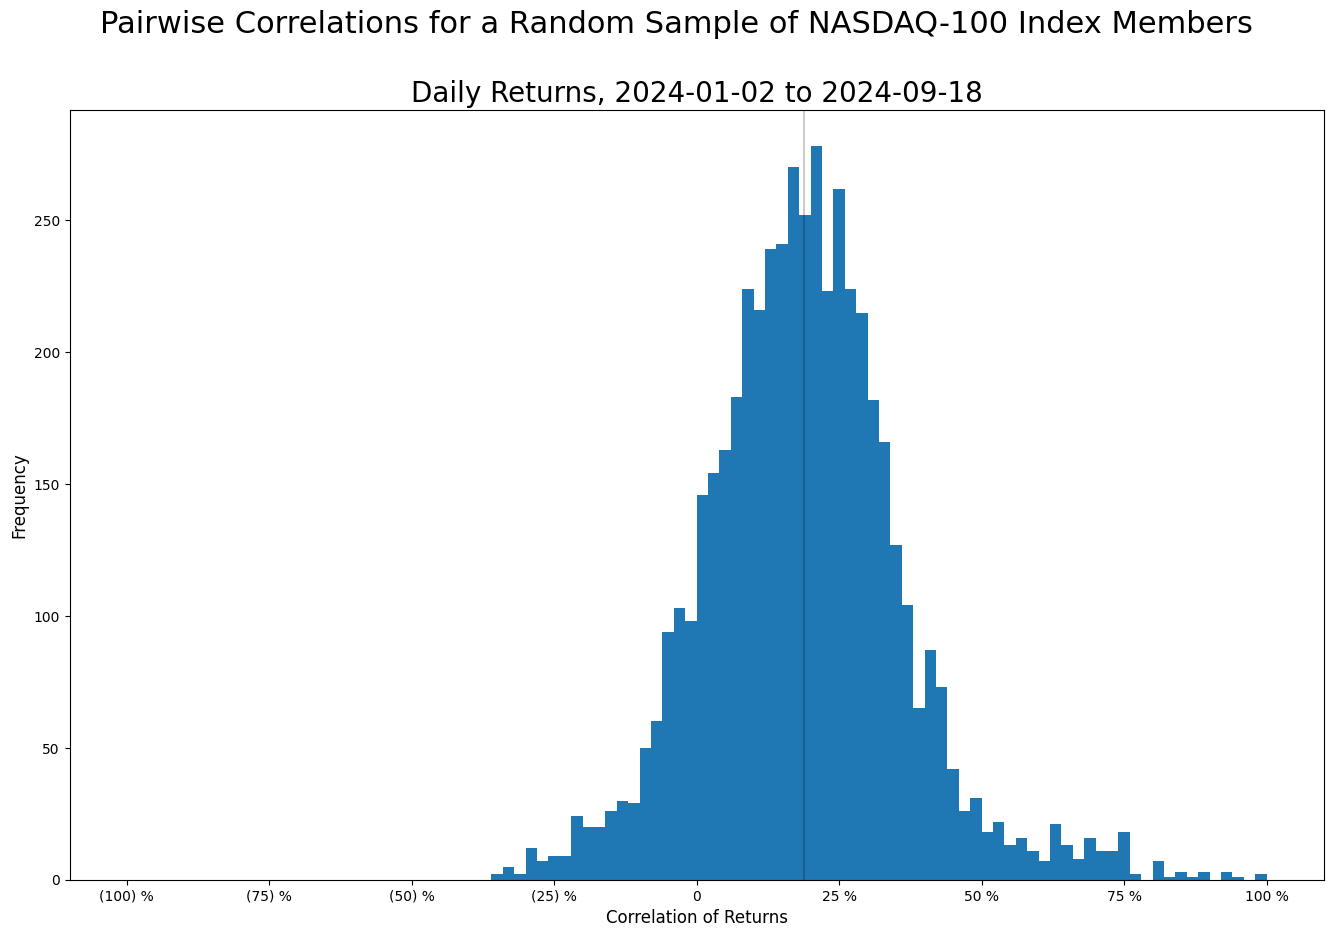

In [20]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
bins,counts,patches=plot.hist(results.loc[results.index!="Mean",'Correlation'].to_numpy(),bins=np.linspace(-hundred,hundred,101))
figure.suptitle(title:="Pairwise Correlations for a Random Sample of %s Index Members" % indexname,fontsize=22)
plot.set_title(subtitle:="Daily Returns, %s to %s" % (first_date,today("%Y-%m-%d")),fontsize=20)
plot.set_xlabel("Correlation of Returns",fontsize=12)
plot.xaxis.set_major_formatter(PercentLabels(0))
plot.set_ylabel("Frequency",fontsize=12)
plot.yaxis.set_major_formatter(CountLabels())
plot.axvline(m,color='black',alpha=0.2)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

### Execute the $N^*$ vs. $N$ Analysis
---
$N^*$ is the effective degrees of freedom found within a portfolio of size $N$. This is computed by comparing the variance of the portfolio returns to the variance we would expect if all the stocks were independent.

In [21]:
results=pd.DataFrame({"Sample":range(1,(n:=1000)+1),"Assets":[np.nan]*n,"Portfolio":[np.nan]*n}).set_index("Sample") # n is number of trials
nprint("Getting daily data for all index stocks, starting on %s." % first_date)
closes=data['Adj Close']
closes.index=pd.DatetimeIndex(closes.index).to_period('B')

nprint("Beginning analysis for {:,d} trials. This may take about {:.1f} minutes...".format(n,n/2.38/60)) # approx empirical timings

if (filter:=None) is not None: # choose "Up", "Down" or None
    nprint("Limiting analysis to portfolio %s days only." % filter.lower())

for i in tqdm(results.index): # for each trial, pick a random sample of stocks with portfolio sizes uniformly distributed between 1 and maximum, one of 2^503-1 choices
    returns=pd.DataFrame()

    for ticker in closes[np.random.choice(closes.columns,np.random.randint(1,closes.shape[1]+1),replace=False)]:
        returns[ticker]=closes[ticker].pct_change().dropna()*hundred # compute all adjusted returns, ticker by ticker

        if returns[ticker].shape[0]<1: # exclude time-series that are all NA's
            returns.drop(columns=ticker,inplace=True)

        else:
            returns=returns.copy() # 'cos it frags, apparently

    returns['Portfolio']=returns.mean(axis=1) # equal weighted portfolio return
    select=(returns["Portfolio"]>zero) if filter=='Up' else (returns["Portfolio"]<zero) if filter=='Down' else (~returns["Portfolio"].isna())
    results.loc[i,"Assets"]=returns.shape[1]-1 # number of assets we ended up with
    results.loc[i,"Independent"]=returns.loc[select,[a for a in returns if a!="Portfolio"]].var().sum()/results.loc[i,"Assets"]**2 # if no correlation, portfolio variance is total variance divided by square of number of assets
    results.loc[i,"Portfolio"]=returns.loc[select,'Portfolio'].var() # variance of portfolio returns for same period as individual returns

results.dropna(inplace=True)
results["Effective D.o.F."]=results["Independent"]/results["Portfolio"]*results["Assets"]
display(results)
nprint("Done.")

17:56:32 Getting daily data for all index stocks, starting on 2024-01-02.
17:56:32 Beginning analysis for 1,000 trials. This may take about 7.0 minutes...


  0%|          | 0/1000 [00:00<?, ?it/s]

,Assets,Portfolio,Independent,Effective D.o.F.
Sample,,,,
1,50.0,1.156195,0.117810,5.094713
2,93.0,0.895419,0.058466,6.072398
3,39.0,0.818965,0.121115,5.767626
4,26.0,1.084717,0.233362,5.593542
5,15.0,0.985717,0.287809,4.379696
...,...,...,...,...
996,68.0,0.871863,0.078337,6.109796
997,99.0,0.978858,0.054855,5.547896
998,55.0,0.961652,0.093375,5.340398


17:58:10 Done.


### Make a Plot

17:58:10 All Days: Effective D.o.F. Limit 5.63, Implied Correlation 16.93 %.


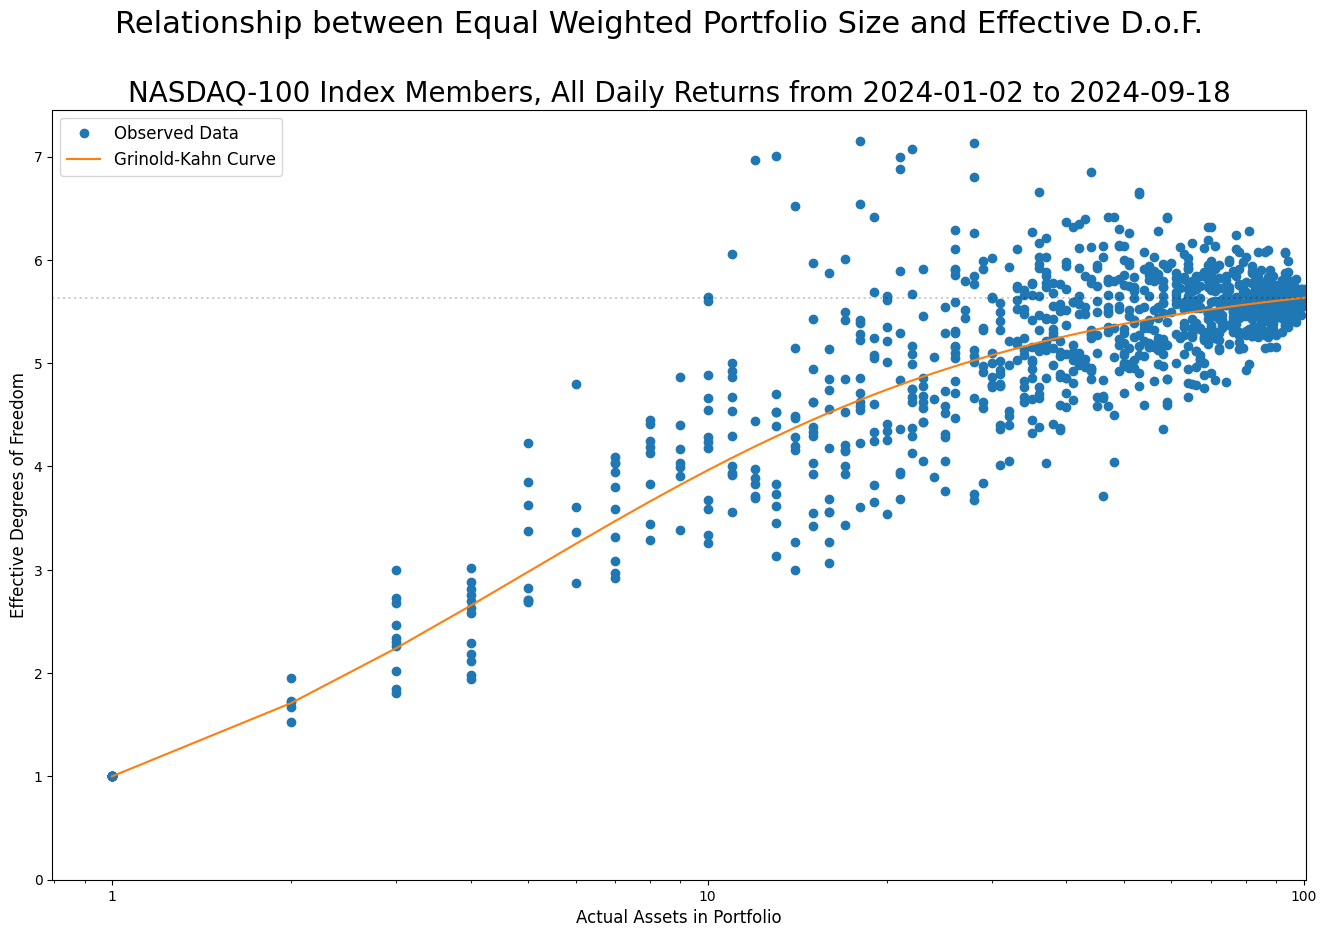

In [22]:
Nstar,Nact=tuple(results.sort_values("Assets").iloc[-1][["Effective D.o.F.","Assets"]])
rho=(Nact-Nstar)/((Nact-one)*Nstar)
nprint("{:s} Days: Effective D.o.F. Limit {:,.2f}, Implied Correlation {:.2f} %.".format(filter if filter is not None else "All",Nstar,rho*hundred))
meta=pd.concat([meta,pd.DataFrame({
    "Name":[(indexname,filter if filter is not None else "")],
     "N":[Nact],
    "N*":[Nstar],
    "rho":[rho]
}).set_index("Name")])

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.plot(x:=results["Assets"].to_numpy(),y:=results["Effective D.o.F."].to_numpy(),'o',label='Observed Data')
plot.plot(xp:=np.append([] if max(x)>100 else [zero],np.unique(np.sort(x))),xp/(one+(xp-one)*rho),'-',label='Grinold-Kahn Curve')
plot.set_xscale('log' if max(x)>100 else 'linear')
plot.set_ylim(zero,None)
plot.set_xlabel("Actual Assets in Portfolio",fontsize=12)
plot.set_ylabel("Effective Degrees of Freedom",fontsize=12)
figure.suptitle(title:="Relationship between Equal Weighted Portfolio Size and Effective D.o.F.",fontsize=22)
plot.set_title("%s Index Members, %s Daily Returns from %s to %s" % (indexname,filter if filter is not None else "All",first_date,pd.Timestamp.today().strftime("%Y-%m-%d")),fontsize=20)
plot.set_xlim(zero,index.shape[0])
plot.legend(fontsize=12)
plot.axhline(Nstar,color='black',linestyle=':',alpha=0.2)
plot.xaxis.set_major_formatter(CountLabels())
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

### Meta-Analysis
---

In [23]:
meta.index=pd.MultiIndex.from_tuples(meta.index)
meta.index.names=("Name","Filter")
display(meta.sort_values("N",ascending=True))

try:
    meta.to_pickle("/content/drive/MyDrive/meta.pickle")
    nprint("Saved meta-analysis results to Google Drive.")

except:
    raise RuntimeError("You need to mount your Google Drive to save results.")

N        N*       rho
Name             Filter                            
Dow                        30.0  5.179205  0.165255
NASDAQ-100                101.0  5.633882  0.169272
                          101.0  5.634579  0.169250
S&P MidCap 400            401.0  3.372589  0.294749
S&P 500                   502.0  4.901689  0.202423
S&P SmallCap 600          602.0  3.497499  0.284730
S&P 900                   904.0  3.964192  0.251430
S&P 1500                 1506.0  4.115399  0.242487

17:58:12 Saved meta-analysis results to Google Drive.


<ipython-input-39-68a2167c04d4>:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  plot.text(x:=meta.loc[i,"N*"].values[0],y:=meta.loc[i,"rho"].values[0]*hundred,s:="\n".join(i),ha='center',va='center',fontsize=10)


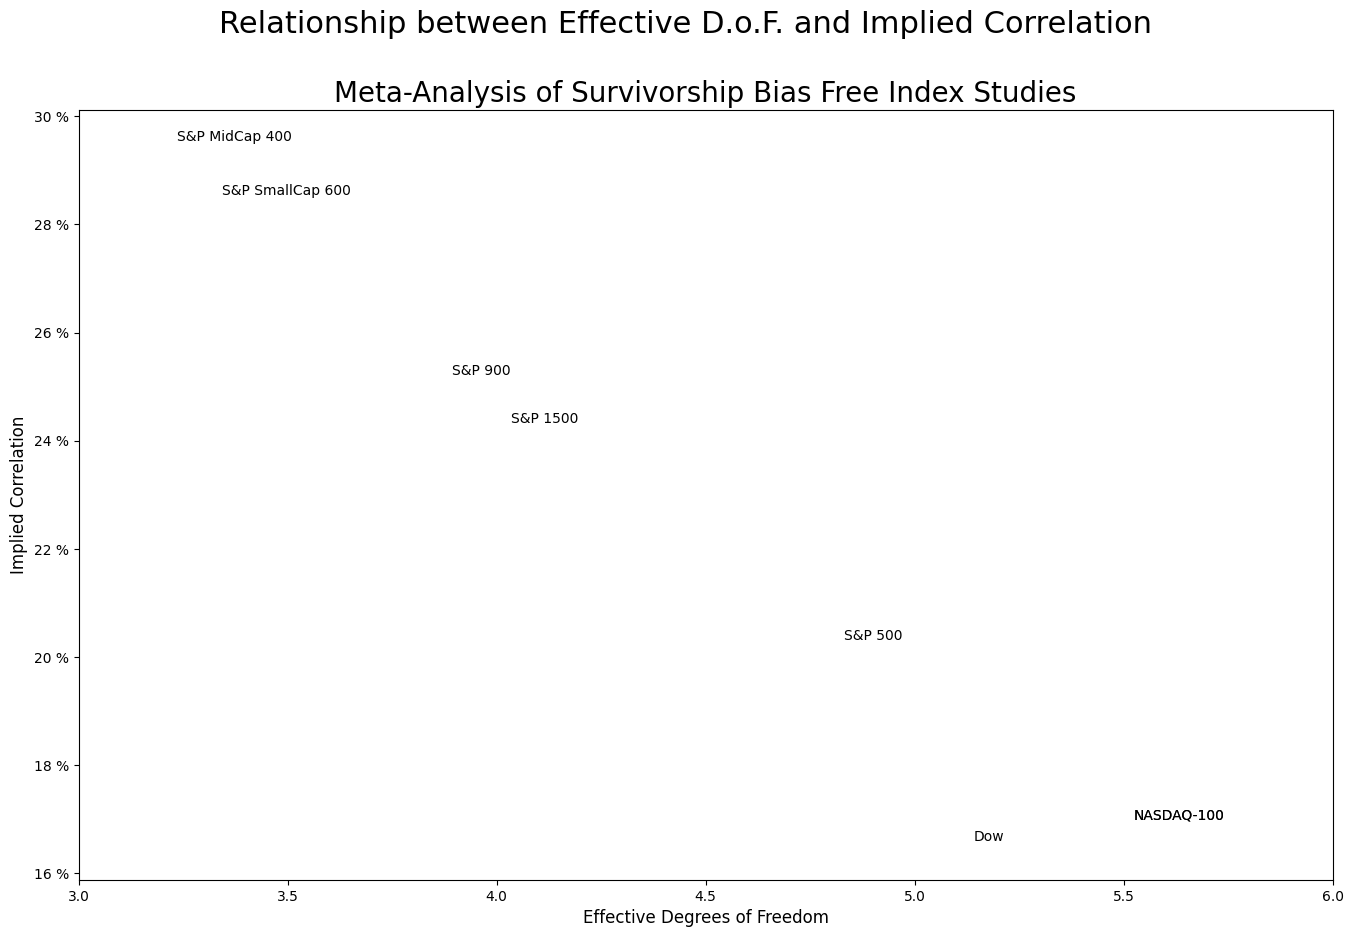

In [39]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.plot(x:=meta["N*"].to_numpy(),y:=meta["rho"].to_numpy()*hundred,'o',label='Observed Data',alpha=zero)
plot.set_xlabel("Effective Degrees of Freedom",fontsize=12)
plot.set_ylabel("Implied Correlation",fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(0))
figure.suptitle(title:="Relationship between Effective D.o.F. and Implied Correlation",fontsize=22)
plot.set_title("Meta-Analysis of Survivorship Bias Free Index Studies",fontsize=20)
plot.set_xlim(np.floor(meta["N*"]).min(),np.ceil(meta["N*"]).max())

for i in meta.index:
    plot.text(x:=meta.loc[i,"N*"].values[0],y:=meta.loc[i,"rho"].values[0]*hundred,s:="\n".join(i),ha='center',va='center',fontsize=10)

figure.savefig(title+".png",dpi=300,bbox_inches='tight')

### $\LaTeX$ Code for the Formulae in the Articles
---

$$
V_P=\mathbb{V}\!\left[\frac{1}{N}\sum_{i=1}^Nr_{it}\right]=\frac{1}{N^2}\mathbb{V}\!\left[\sum_{i=1}^Nr_{it}\right]
$$

$$
V_P=\frac{1}{N^2}\sum_{i=1}^N\sigma_i^2+\frac{2}{N^2}\sum_{i=1}^N\sum_{j=i+1}^N\sigma_i\sigma_j\rho_{ij}=V_I+V_C
$$

$$
V_I=\frac{1}{N}\left(\frac{1}{N}\sum_{i=1}^N\sigma_i^2\right)=\frac{\overline{\sigma^2}}{N}
$$

$$
\mathbb{V}[\bar{x}]=\frac{\sigma^2}{N}\;\mathrm{where}\;\mathbb{V}[x_i]=\mathbb{V}[x_j]=\sigma^2\;\mathrm{and}\;\mathbb{C}[x_i,x_j]=0\;\forall\;i,j
$$

$$
V_P=V_I\left(1+\frac{V_C}{V_I}\right)=\frac{\overline{\sigma^2}}{N}\left(1+\frac{V_C}{V_I}\right)
$$

$$
V_P=\frac{\overline{\sigma^2}}{N^*}\;\mathrm{where}\;N^*=N\frac{V_I}{V_P}
$$

$$
\sum_{N=1}^M\begin{pmatrix}M\\ N\end{pmatrix}=2^M-1
$$

$$
2^{503}-1\approx3.3\times10^{150}
$$

$$
\mathbb{V}[r_{it},r_{jt}]=\sigma_{it}\sigma_{jt}\rho\;\Leftrightarrow\;V_t=S_tRS_t\;\mathrm{where}\;R=\begin{pmatrix}
1&\rho&\cdots&\rho\\
\rho&1&\cdots&\rho\\
\vdots&&\ddots&\vdots\\
\rho&\rho&\cdots&1
\end{pmatrix}\;\mathrm{and}\;
S_t=\begin{pmatrix}
\sigma_{1t}&0&\cdots&0\\
0&\sigma_{2t}&\cdots&0\\
\vdots&&\ddots&\vdots\\
0&0&\cdots&\sigma_{Nt}
\end{pmatrix}
$$